In [1]:
!kaggle datasets download -d gpiosenka/butterfly-images40-species

/bin/bash: /home/wonje/anaconda3/envs/ML/lib/libtinfo.so.6: no version information available (required by /bin/bash)
100%|████████████████████████████████████████| 454M/454M [00:30<00:00, 10.4MB/s]
100%|████████████████████████████████████████| 454M/454M [00:30<00:00, 15.8MB/s]


In [3]:
from zipfile import ZipFile

with ZipFile("butterfly-images40-species.zip", 'r') as zipWriter:
    zipWriter.extractall('./data')

In [179]:
import os
import cv2

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear

from torch.utils.data import Dataset, RandomSampler, DataLoader
from torchvision import transforms as T
import torchvision.models as models

In [165]:
print(os.listdir("./data"))

DIR_TRAIN = "./data/train"
DIR_VALID = "./data/valid"
DIR_TEST = "./data/test"

['BUTTERFLIES.csv', 'valid', 'train', 'test', 'BUTTERFLIES-97.77.h5']


In [166]:
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

train_count = 0
valid_count = 0
test_count = 0

train_paths = []
valid_paths = []
test_paths = []

for _class in classes:
    for img in os.listdir(f"{DIR_TRAIN}/{_class}"):
        train_paths.append(f"{DIR_TRAIN}/{_class}/{img}")
        train_count += 1
    for img in os.listdir(f"{DIR_VALID}/{_class}"):
        valid_paths.append(f"{DIR_VALID}/{_class}/{img}")
        valid_count += 1
    for img in os.listdir(f"{DIR_TEST}/{_class}"):
        test_paths.append(f"{DIR_TEST}/{_class}/{img}")
        test_count += 1
class_to_int = {classes[i]: i for i in range(len(classes))}


print(len(train_paths))
print(len(valid_paths))
print(len(test_paths))

Total Classes:  100
12639
500
500


In [167]:
def getTransforms():
    return T.Compose([T.ToTensor()])

class ButterflyAndMothDataset(Dataset):
    def __init__(self, imgs_list, class_to_int, transforms=None):
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img_path = self.imgs_list[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.
        
        label = img_path.split("/")[-2]
        label = self.class_to_int[label]
        
        if self.transforms != None:
            img = self.transforms(img)
            
        return img, label
    
    def __len__(self):
        return len(self.imgs_list)

train_dataset = ButterflyAndMothDataset(train_paths, class_to_int, getTransforms())
valid_dataset = ButterflyAndMothDataset(valid_paths, class_to_int, getTransforms())
test_dataset = ButterflyAndMothDataset(test_paths, class_to_int, getTransforms())

In [168]:
train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    sampler=train_random_sampler
)
valid_data_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=64,
    sampler=valid_random_sampler
)
test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    sampler=test_random_sampler
)

In [169]:
model = models.resnet152(pretrained=True)
model.fc = Linear(2048, 100)

for named_child in model.named_children():
    isFc = (named_child[0] == 'fc')
    for parameter in named_child[1].parameters():
        parameter.requires_grad = isFc

In [170]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_acc = []

val_loss = []
val_acc = []

epochs = 50

In [171]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [182]:
### Training Code
from tqdm import tqdm
from time import time

for epoch in range(epochs):
    
    start = time()
    
    train_epoch_loss = []
    train_epoch_acc = []
    
    val_epoch_loss = []
    val_epoch_acc = []
    
    # Training
    for images, labels in tqdm(train_data_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Reset Grads
        optimizer.zero_grad()
    
        # Forward
        y_hat = model(images)
        
        # Calculate Acc
        train_epoch_acc.append(calc_accuracy(labels.cpu(), y_hat.cpu()))
        
        # Backward
        loss = criterion(y_hat, labels)
        loss.backward()
        optimizer.step()
        
        train_epoch_loss.append(loss.item())
        
    # Validation
    for images, labels in tqdm(valid_data_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        y_hat = model(images)
        val_epoch_acc.append(calc_accuracy(labels.cpu(), y_hat.cpu()))
        val_epoch_loss.append(criterion(y_hat, labels).item())
        
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_acc = np.mean(train_epoch_acc)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_acc = np.mean(val_epoch_acc)
    
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)
    
    end = time()

    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_acc))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_acc))
    

  8%|███▍                                      | 16/198 [00:02<00:28,  6.43it/s]


KeyboardInterrupt: 

In [188]:
### Testing Code

accuracies = []

for images, labels in tqdm(test_data_loader):
    
    images = images.to(device)
    labels = labels.to(device)
    
    y_hat = model(images)
    
    acc = calc_accuracy(labels.cpu(), y_hat.cpu())
    
    accuracies.append(acc)
    
print(f"Accuracy: {round(np.mean(accuracies), 2)} %")

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  6.87it/s]

Accuracy: 94.2 %


Accuracy: 94.2 %

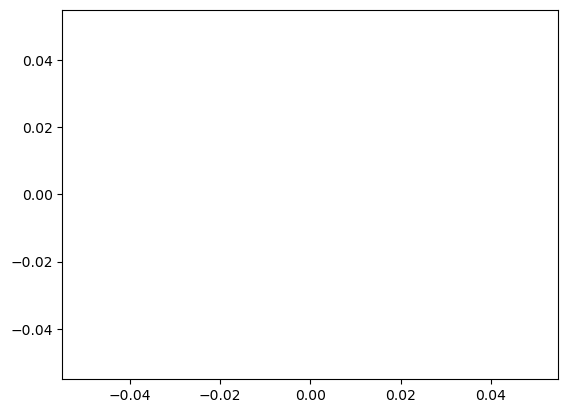

In [184]:
# Accuracy Analysis
plt.plot(train_acc)
plt.plot(val_acc)
plt.show()

In [ ]:
# Loss Analysis
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()